## Prepare imports

In [1]:
import torch
import matplotlib.pyplot as plt
from omegaconf import OmegaConf

from models.vae import VanillaVAE
from models.vae import BaseModel as BaseVAE
from models.encoder import BaseModel as EctEncoder
from layers.ect import EctLayer, EctConfig

from metrics.metrics import get_mse_metrics
from metrics.accuracies import compute_mse_accuracies
from metrics.loss import compute_mse_loss_fn
from layers.directions import generate_directions
from datasets import load_datamodule

DEVICE = "cuda:0"
import pyvista as pv




KeyboardInterrupt: 

## Load Models and Data

In [ ]:
config = OmegaConf.load("./configs/config_encoder_shapenet_airplane.yaml")
dm = load_datamodule(config.data)


Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!


In [ ]:
layer = EctLayer(
    EctConfig(
        num_thetas=config.layer.ect_size,
        bump_steps=config.layer.ect_size,
        normalized=True,
        device=DEVICE,
    ),
    v=generate_directions(config.layer.ect_size, config.layer.dim, DEVICE),
)




In [ ]:

# # Load the encoder 

ect_encoder_litmodel = EctEncoder.load_from_checkpoint(
    f"./trained_models/ectencoder_shapenet_{config.data.categories[0]}.ckpt",
    layer=layer,
    ect_size=config.layer.ect_size,
    hidden_size=config.model.hidden_size,
    num_pts=config.model.num_pts,
    num_dims=config.model.num_dims,
    learning_rate=config.model.learning_rate,
).to(DEVICE)

In [ ]:
data_loader = dm.val_dataloader()
for batch_idx, features in enumerate(data_loader):
    if batch_idx==1:
        break

features.to(DEVICE)
ect = layer(features,features.batch).unsqueeze(1)
decoded = torch.zeros_like(ect)

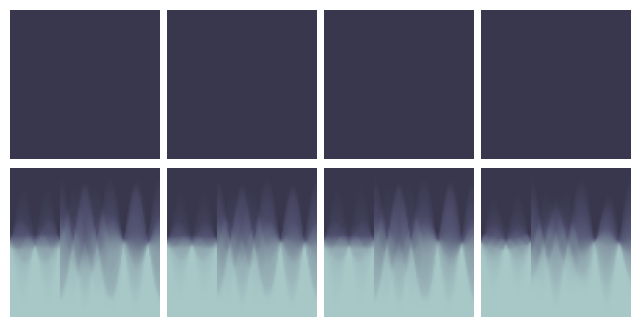

In [ ]:
n_images = 4

fig, axes = plt.subplots(
    nrows=2, ncols=n_images, sharex=True, sharey=True, figsize=(8,4)
)
fig.subplots_adjust(wspace=0.05,hspace=0.05)

for orig_img, recon_img,ax in zip(ect,decoded,axes.T):
    
    ax[0].imshow(recon_img.cpu().detach().squeeze().numpy(),cmap="bone",vmin=-0.5,vmax=1.5)
    ax[0].axis("off")
    ax[1].imshow(orig_img.cpu().detach().squeeze().numpy(),cmap="bone",vmin=-0.5,vmax=1.5)
    ax[1].axis("off")
    

# plt.savefig("./figures/img/modelnet/reconstructed_ect_vae.svg",transparent=True)

# Original PointClouds

In [ ]:
pl = pv.Plotter(shape=(8,8), window_size=[1600, 1600],border=False,polygon_smoothing=True)

for row in range(8):
    for col in range(8):
        points = features[row*col + col].x.reshape(-1, 3).detach().cpu().numpy()
        pl.subplot(row, col)
        actor = pl.add_points(
            points,
            style="points",
            emissive=False,
            show_scalar_bar=False,
            render_points_as_spheres=True,
            scalars=points[:, 2],
            point_size=5,
            ambient=0.2, 
            diffuse=0.8, 
            specular=0.8,
            specular_power=40, 
            smooth_shading=True
        )


pl.background_color = "w"
pl.link_views()
pl.camera_position = "yz"
pos = pl.camera.position
pl.camera.position = (pos[0],pos[1],pos[2]+3)
pl.camera.azimuth = -45
pl.camera.elevation = 10
# create a top down light
light = pv.Light(position=(0, 0, 3), positional=True,
                cone_angle=50, exponent=20, intensity=.2)
pl.add_light(light)
pl.camera.zoom(1.3)
pl.show()

Widget(value='<iframe src="http://localhost:64944/index.html?ui=P_0x26aa42c77f0_0&reconnect=auto" class="pyvis…

# Reconstructed PointClouds

In [ ]:

pl = pv.Plotter(shape=(8,8), window_size=[1600, 1600],border=False,polygon_smoothing=True)

with torch.no_grad():
    batch_decoded = ect_encoder_litmodel.model.forward(ect).cpu().detach().numpy()


for row in range(8):
    for col in range(8):
        points = batch_decoded[row*col + col].reshape(-1, 3)
        pl.subplot(row, col)
        actor = pl.add_points(
            points,
            style="points",
            emissive=False,
            show_scalar_bar=False,
            render_points_as_spheres=True,
            scalars=points[:, 2],
            point_size=5,
            ambient=0.2, 
            diffuse=0.8, 
            specular=0.8,
            specular_power=40, 
            smooth_shading=True
        )


pl.background_color = "w"
pl.link_views()
pl.camera_position = "yz"
pos = pl.camera.position
pl.camera.position = (pos[0],pos[1],pos[2]+3)
pl.camera.azimuth = -45
pl.camera.elevation = 10
# create a top down light
light = pv.Light(position=(0, 0, 3), positional=True,
                cone_angle=50, exponent=20, intensity=.2)
pl.add_light(light)
pl.camera.zoom(1.3)
pl.show()

Widget(value='<iframe src="http://localhost:64944/index.html?ui=P_0x26d0f8259c0_1&reconnect=auto" class="pyvis…

In [ ]:



with torch.no_grad():

    recon_batch = ect_encoder_litmodel.model.forward(ect).cpu().detach().numpy()
    recon_batch_vae = ect_encoder_litmodel.model.forward(decoded).cpu().detach().numpy()


pl = pv.Plotter(shape=(2, 4), window_size=[800, 400],border=False,polygon_smoothing=True,off_screen=True)


row = 3
for col in range(4):
    points_vae = recon_batch_vae[row*8 + col].reshape(-1, 3)
    pl.subplot(0, col)
    actor = pl.add_points(
        points_vae,
        style="points",
        emissive=False,
        show_scalar_bar=False,
        render_points_as_spheres=True,
        scalars=points_vae[:, 2],
        point_size=5,
        ambient=0.2, 
        diffuse=0.8, 
        specular=0.8,
        specular_power=40, 
        smooth_shading=True
    )
    points = recon_batch[row*8 + col].reshape(-1, 3)
    pl.subplot(1,  col)
    actor = pl.add_points(
        points,
        style="points",
        emissive=False,
        show_scalar_bar=False,
        render_points_as_spheres=True,
        scalars=points[:, 2],
        point_size=5,
        ambient=0.2, 
        diffuse=0.8, 
        specular=0.8,
        specular_power=40, 
        smooth_shading=True
    )
    


pl.background_color = "w"
pl.link_views()
pl.camera_position = "yz"
pos = pl.camera.position
pl.camera.position = (pos[0],pos[1],pos[2]+3)
pl.camera.azimuth = -45
pl.camera.elevation = 10

# create a top down light
light = pv.Light(position=(0, 0, 3), positional=True,
                cone_angle=50, exponent=20, intensity=.2)
pl.add_light(light)
pl.camera.zoom(1.3)
# pl.screenshot("./figures/img/modelnet/reconstructed_vae_pointcloud.png",transparent_background=True,scale=2)
pl.show()
path = pl.generate_orbital_path(n_points=64, shift=2, factor=3.0)
# pl.open_gif("./figures/img/modelnet/orbit_vae_cloud.gif")
# pl.orbit_on_path(path, write_frames=True)
pl.close()


Widget(value='<iframe src="http://localhost:64944/index.html?ui=P_0x26d4159f970_3&reconnect=auto" class="pyvis…

# Reconstruct the pointcloud with a VAE

In [ ]:
vae_model = VanillaVAE(in_channels=1, latent_dim=64,img_size=config.layer.ect_size)






# Load the VAE model

metrics = get_mse_metrics()

vae_litmodel = BaseVAE.load_from_checkpoint(
    f"./trained_models/vae_shapenet_{config.data.categories[0]}.ckpt",
    model=vae_model,
    training_accuracy=metrics[0],
    test_accuracy=metrics[1],
    validation_accuracy=metrics[2],
    accuracies_fn=compute_mse_accuracies,
    loss_fn=compute_mse_loss_fn,
    learning_rate=0.01,
    layer=layer,
).to(DEVICE)

# vae_litmodel.eval()

In [ ]:
vae_litmodel.model

VanillaVAE(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (4): Se

In [ ]:
with torch.no_grad():
    decoded, theinput, z_mean, z_log_var = vae_litmodel.forward(ect)

# Undo the VAE transform
decoded = (decoded + 1 ) / 2


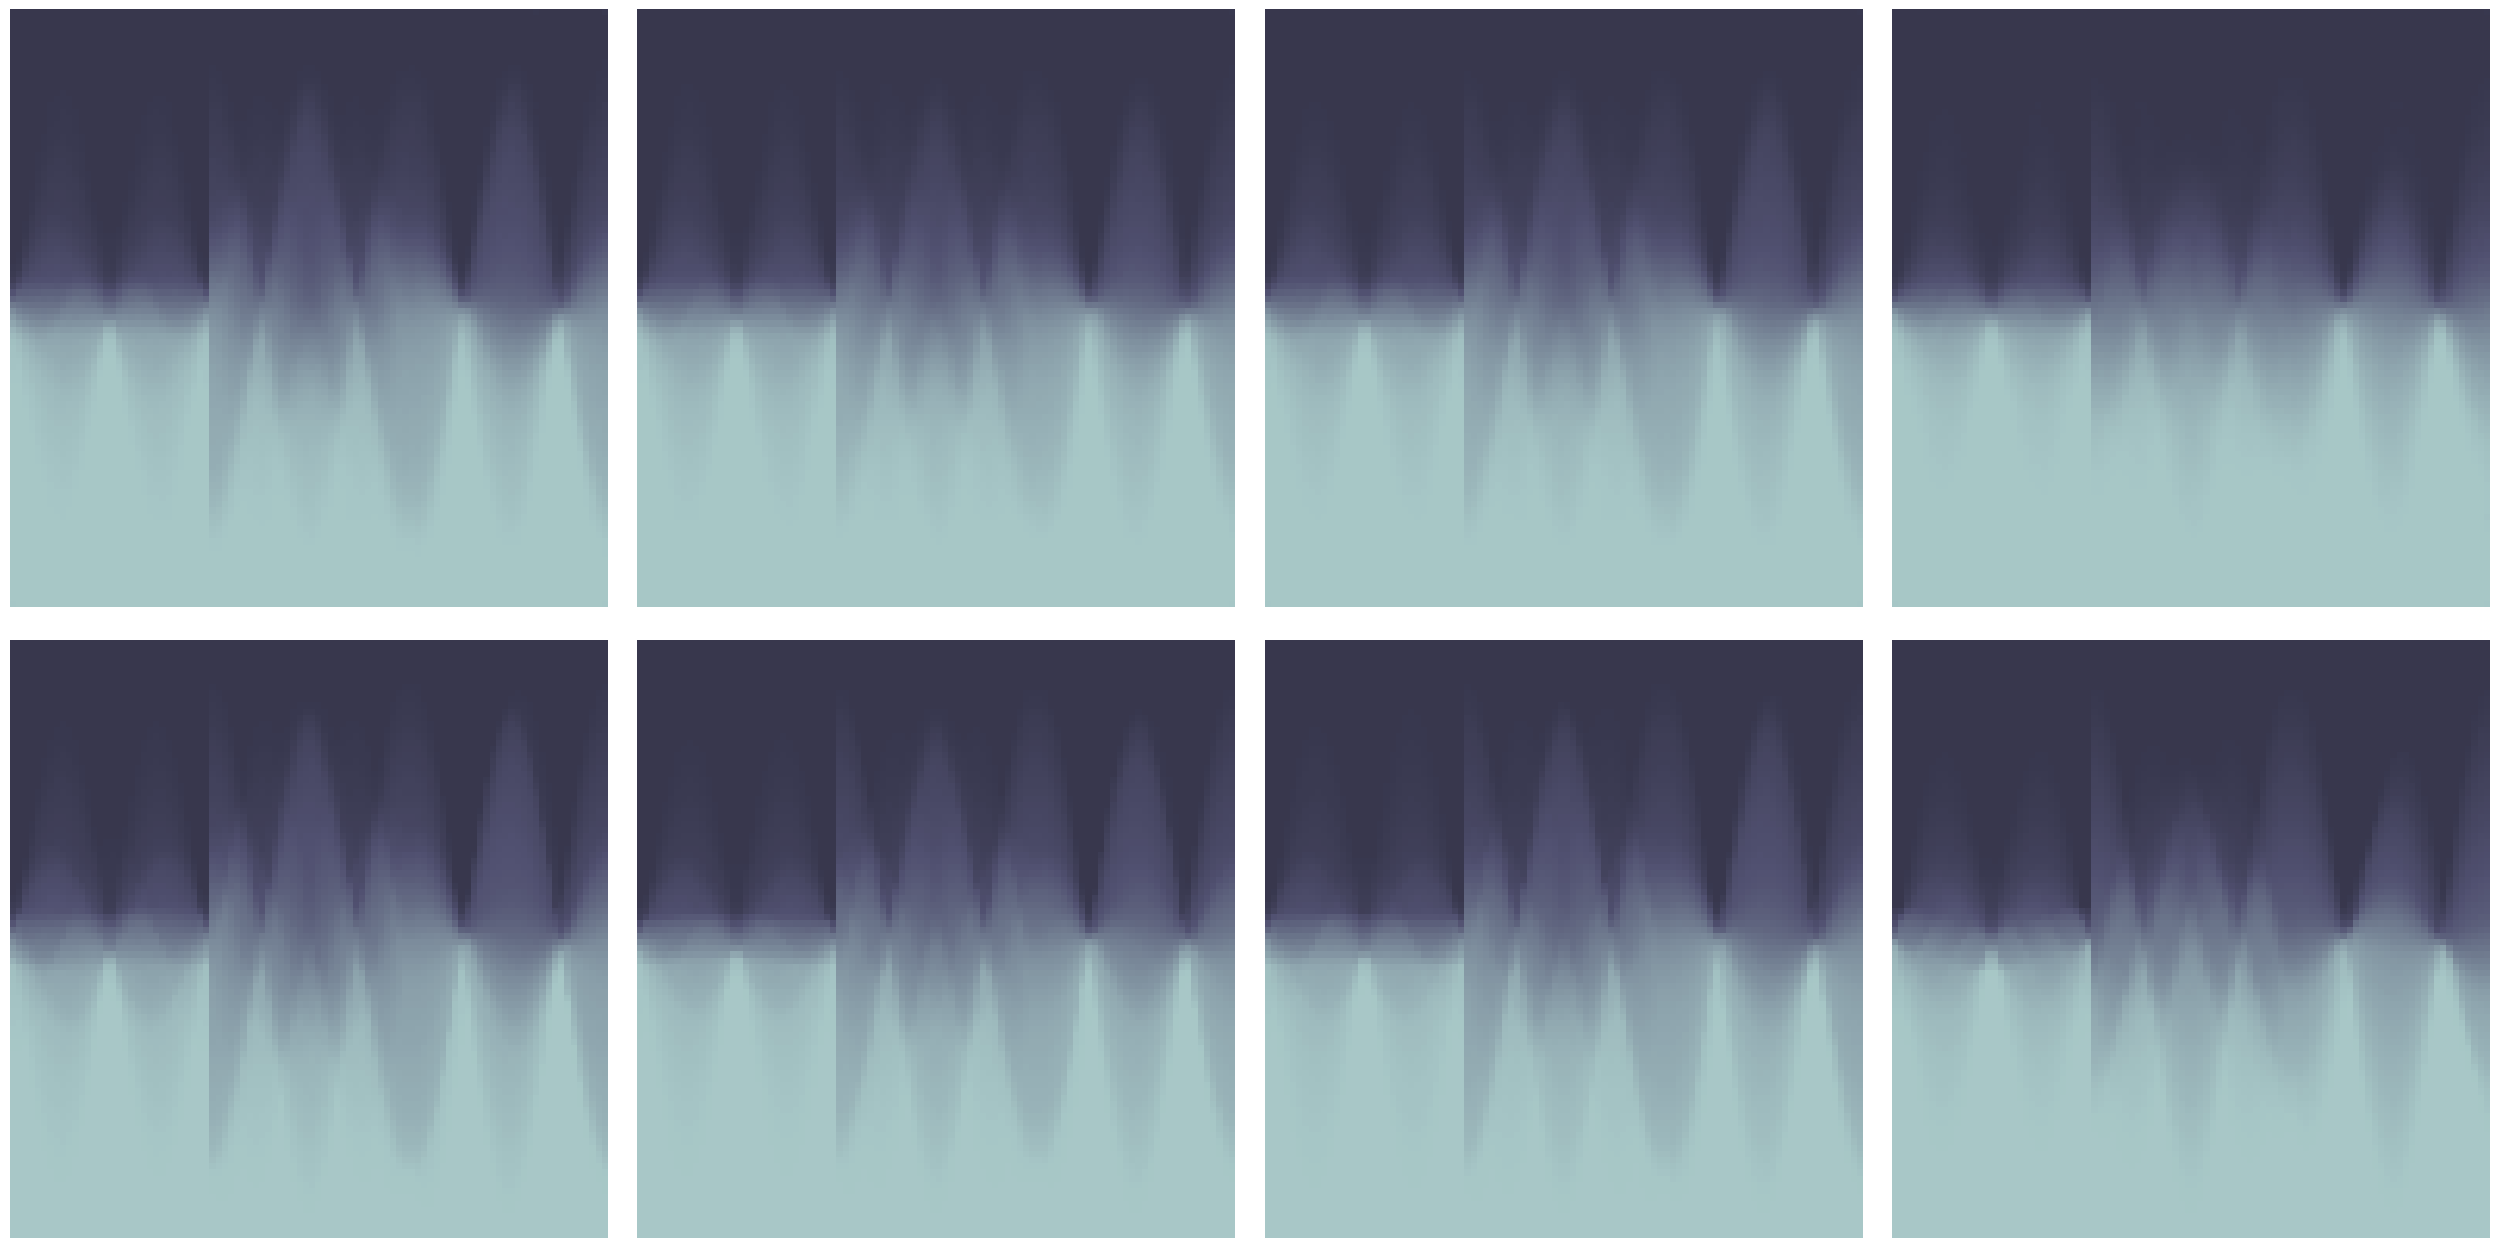

In [ ]:
n_images = 4

fig, axes = plt.subplots(
    nrows=2, ncols=n_images, sharex=True, sharey=True, figsize=(32,16)
)
fig.subplots_adjust(wspace=0.05,hspace=0.05)

for orig_img, recon_img,ax in zip(ect,decoded,axes.T):
    
    ax[0].imshow(recon_img.cpu().detach().squeeze().numpy(),cmap="bone",vmin=-0.5,vmax=1.5)
    ax[0].axis("off")
    ax[1].imshow(orig_img.cpu().detach().squeeze().numpy(),cmap="bone",vmin=-0.5,vmax=1.5)
    ax[1].axis("off")

Widget(value='<iframe src="http://localhost:64944/index.html?ui=P_0x26d20709a50_3&reconnect=auto" class="pyvis…

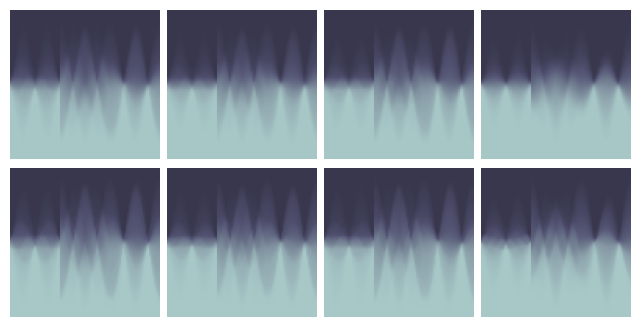

In [ ]:
# data_loader = dm.val_dataloader()
# for batch_idx, features in enumerate(data_loader):
#     break

features.to(DEVICE)
ect = layer(features,features.batch).unsqueeze(1)

with torch.no_grad():
    decoded, theinput, z_mean, z_log_var = vae_litmodel.forward(ect)

# Undo the VAE transform
decoded = (decoded + 1 ) / 2



with torch.no_grad():
    recon_batch_vae = ect_encoder_litmodel.model.forward(decoded).cpu().detach().numpy()


pl = pv.Plotter(shape=(8,8), window_size=[1600, 1600],border=False,polygon_smoothing=True)



for row in range(8):
    for col in range(8):
        points = recon_batch_vae[row*col + col].reshape(-1, 3)
        pl.subplot(row, col)
        actor = pl.add_points(
            points,
            style="points",
            emissive=False,
            show_scalar_bar=False,
            render_points_as_spheres=True,
            scalars=points[:, 2],
            point_size=5,
            ambient=0.2, 
            diffuse=0.8, 
            specular=0.8,
            specular_power=40, 
            smooth_shading=True
        )


pl.background_color = "w"
pl.link_views()
pl.camera_position = "yz"
pos = pl.camera.position
pl.camera.position = (pos[0],pos[1],pos[2]+3)
pl.camera.azimuth = -45
pl.camera.elevation = 10
# create a top down light
light = pv.Light(position=(0, 0, 3), positional=True,
                cone_angle=50, exponent=20, intensity=.2)
pl.add_light(light)
pl.camera.zoom(1.3)
pl.show()


n_images = 4

fig, axes = plt.subplots(
    nrows=2, ncols=n_images, sharex=True, sharey=True, figsize=(8,4)
)
fig.subplots_adjust(wspace=0.05,hspace=0.05)

for orig_img, recon_img,ax in zip(ect,decoded,axes.T):
    
    ax[0].imshow(recon_img.cpu().detach().squeeze().numpy(),cmap="bone",vmin=-0.5,vmax=1.5)
    ax[0].axis("off")
    ax[1].imshow(orig_img.cpu().detach().squeeze().numpy(),cmap="bone",vmin=-0.5,vmax=1.5)
    ax[1].axis("off")

## Sample from VAE and reconstruct points 

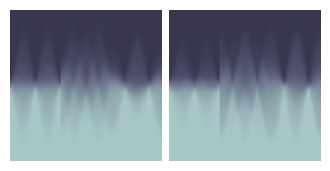

In [ ]:
samples = vae_litmodel.model.sample(64, "cuda:0")
samples = (samples + 1 ) / 2

n_images = 2

fig, axes = plt.subplots(
    nrows=1, ncols=n_images, sharex=True, sharey=True, figsize=(4,4)
)
fig.subplots_adjust(wspace=0.05,hspace=0.05)

for sample, ax in zip(samples,axes.T):
    ax.imshow(sample.cpu().detach().squeeze().numpy(),cmap="bone",vmin=-0.5,vmax=1.5)
    ax.axis("off")

# plt.savefig("./figures/img/modelnet/generated_samples.svg",transparent=True)




In [ ]:

import pyvista as pv

pl = pv.Plotter(shape=(1, 8), window_size=[1600, 200],border=False,polygon_smoothing=True)

with torch.no_grad():
    batch_decoded = ect_encoder_litmodel.model.forward(samples)

batch_decoded = batch_decoded.cpu().detach().numpy()

for col in range(8):
    points = batch_decoded[col].reshape(-1, 3)
    pl.subplot(0,col)
    actor = pl.add_points(
        points,
        style="points",
        emissive=False,
        show_scalar_bar=False,
        render_points_as_spheres=True,
        scalars=points[:, 2],
        point_size=5,
        ambient=0.2, 
        diffuse=0.8, 
        specular=0.8,
        specular_power=40, 
        smooth_shading=True
    )





pl.background_color = "w"
pl.link_views()
pl.camera_position = "yz"
pos = pl.camera.position
pl.camera.position = (pos[0],pos[1],pos[2]+3)
pl.camera.azimuth = -45
pl.camera.elevation = 10

# create a top down light
light = pv.Light(position=(0, 0, 3), positional=True,
                cone_angle=50, exponent=20, intensity=.2)
pl.add_light(light)
pl.camera.zoom(1.3)
# pl.screenshot("./figures/img/modelnet/generated_samples.png",transparent_background=True,scale=2)
pl.show()

Widget(value='<iframe src="http://localhost:64944/index.html?ui=P_0x26d5e103c10_4&reconnect=auto" class="pyvis…